In [275]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import notebook

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import transformers
from transformers import BertModel, BertTokenizer, AdamW

In [ ]:
device = torch.device('cuda')

## Загрузка и предобработка данных

In [276]:
path = '/content/drive/MyDrive/Colab Notebooks/DataSets/'

train = pd.read_csv(path+'train_data.csv', index_col=0)
test = pd.read_csv(path+'test_data.csv', index_col=1)
output = pd.read_csv(path+'test_data.csv') # Нетронутый тестовый файл

In [ ]:
train.info()
train.head(10)

In [ ]:
test.info()
test.head(10)

- Тренировочную выборку нужно перемешать, чтобы классы не шли подряд.
- В тестовой выборке присутствуют пропуски, их заполню пустыми строками, чтобы выборка на выходе имела такую же размерность.
- Для финального тестирования буду использовать заголовки новостей.

In [279]:
train = train.sample(frac=1)
test = test.drop(columns=['Unnamed: 0', 'text']).fillna(' ')

In [280]:
train['label'].value_counts(normalize=True)

0    0.802876
1    0.197124
Name: label, dtype: float64

Имеется дисбаланс классов, нужно будет это учесть при обучении модели.

In [281]:
# Очистка текста от ненужных символов

def regex_cleaning(row):
    return " ".join(re.sub(r'[^а-яА-Я]', ' ', row).split()).lower()

train['sentence'] = train['sentence'].apply(regex_cleaning)
test['title'] = test['title'].apply(regex_cleaning)
#test['text'] = test['text'].apply(regex_cleaning)

Максимальная длина строки в тренировочной выборке: 113


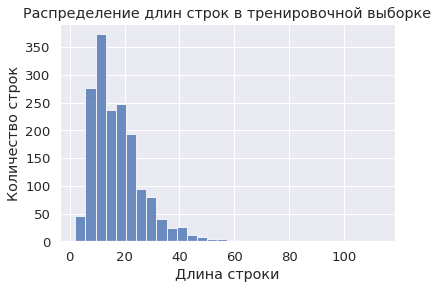

In [282]:
train_sent_len = [len(i.split()) for i in train['sentence']]
test_sent_len = [len(i.split()) for i in test['title']]

print('Максимальная длина строки в тренировочной выборке:', max(train_sent_len))
plt.hist(train_sent_len, bins=30, alpha=0.8)
plt.title('Распределение длин строк в тренировочной выборке')
plt.xlabel('Длина строки')
plt.ylabel('Количество строк');

Максимальная длина строки в тестовой выборке: 35


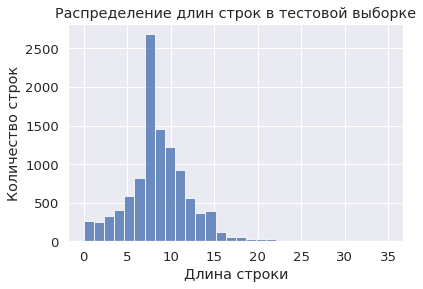

In [283]:
print('Максимальная длина строки в тестовой выборке:', max(test_sent_len))
plt.hist(test_sent_len, bins=30, alpha=0.8)
plt.title('Распределение длин строк в тестовой выборке')
plt.xlabel('Длина строки')
plt.ylabel('Количество строк');

Большая часть строк имеет длину до 40 символов, возьму это число как максимальную длину при токенизации.

## Моделирование

### Подготовка данных

#### Токенизация

In [284]:
X_train, X_valid, y_train, y_valid = train_test_split(train['sentence'], train['label'], 
                                                      random_state=12345, 
                                                      test_size=0.1, 
                                                      stratify=train['label'])

In [285]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')
bert = BertModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

In [286]:
max_sent_len = 40

def tokenize(data):
    tokenized = tokenizer.batch_encode_plus(data.tolist(),
                                            max_length = max_sent_len,
                                            padding=True,
                                            truncation=True,
                                            return_token_type_ids=False)
    return tokenized

# Токенизация выборок
tokens_train = tokenize(X_train)
tokens_valid = tokenize(X_valid)
tokens_test = tokenize(test['title'])

In [287]:
# Перевод токенов в тензоры
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

val_seq = torch.tensor(tokens_valid['input_ids'])
val_mask = torch.tensor(tokens_valid['attention_mask'])
val_y = torch.tensor(y_valid.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

#### DataLoaders

In [288]:
batch_size = 32

# Оборачиваем данные в тензор, обозначаем семплер и создаем DataLoader для выгрузки батчей
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)   # Случайный для обучения
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# То же самое для валидационной выборки
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)   # Последовательный для валидации
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [289]:
# Заморозим параметры берта, чтобы обучались только дополнительные слои
for param in bert.parameters():
    param.requires_grad = False

### Создание модели

In [290]:
class BERT(nn.Module):

    def __init__(self, bert):
        super(BERT, self).__init__()
        self.bert = bert 
        self.dropout = nn.Dropout(0.3)
        self.relu =  nn.ReLU()

        self.fc1 = nn.Linear(768,512) # Первый полносвязный слой
        self.fc2 = nn.Linear(512,2) # Второй (выходной)

        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        # Собираем дополнительные слои
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x

In [291]:
# Инициализация собранной модели и перевод на GPU
model = BERT(bert)
model = model.to(device)

В датасете имеется дисбаланс классов, из-за этого нужно расчитать веса каждого класса и пихнуть их в функцию потерь.

In [292]:
# Расчет весов классов
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights

array([0.62271973, 2.53716216])

In [293]:
# Перевод весов в тензоры
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)

# Функция потерь
cross_entropy  = nn.NLLLoss(weight=weights) 

# Оптимизатор
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


### Функции обучения и валидации

In [294]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds=[]

    for step,batch in enumerate(train_dataloader):
        batch = [r.to(device) for r in batch]   # Перевод батча на GPU
        sent_id, mask, labels = batch
        model.zero_grad()   # Очистка предыдущих градиентов

        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)    # Расчет потерь на текущем батче
        total_loss = total_loss + loss.item()
        loss.backward()    # Расчет градиентов с проходом назад

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # Обрезка градиентов для избежания градиентного взрыва
        optimizer.step()   # Обновление параметров оптимизатора

        preds=preds.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)   # Расчет потерь на эпохе
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [295]:
def evaluate():
    print("Evaluating...")
    model.eval()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step,batch in enumerate(val_dataloader):
        batch = [t.to(device) for t in batch]   # Перевод батча на GPU
        sent_id, mask, labels = batch

        # Расчет предсказаний и потерь без вычисления градиентов
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds,labels)
            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)   # Расчет потерь на эпохе
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

### Обучение и валидация модели

In [296]:
epochs = 30

# Установка начальной потери на бесконечности
best_valid_loss = float('inf')

train_losses=[]
valid_losses=[]

# Путь сохранения весов модели
weights_path = '/content/drive/MyDrive/Colab Notebooks/DataSets/saved_weights.pt'

# Обучение
for epoch in range(epochs):
    print(f'\n Epoch {epoch + 1} / {epochs}')
    
    train_loss, _ = train()
    valid_loss, _ = evaluate()

    # Сохранение потерь и весов лучшей модели
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), weights_path)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'Training Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 30
Evaluating...
Training Loss: 0.627
Validation Loss: 0.531

 Epoch 2 / 30
Evaluating...
Training Loss: 0.516
Validation Loss: 0.504

 Epoch 3 / 30
Evaluating...
Training Loss: 0.485
Validation Loss: 0.532

 Epoch 4 / 30
Evaluating...
Training Loss: 0.517
Validation Loss: 0.708

 Epoch 5 / 30
Evaluating...
Training Loss: 0.511
Validation Loss: 0.466

 Epoch 6 / 30
Evaluating...
Training Loss: 0.471
Validation Loss: 0.446

 Epoch 7 / 30
Evaluating...
Training Loss: 0.458
Validation Loss: 0.431

 Epoch 8 / 30
Evaluating...
Training Loss: 0.461
Validation Loss: 0.439

 Epoch 9 / 30
Evaluating...
Training Loss: 0.454
Validation Loss: 0.438

 Epoch 10 / 30
Evaluating...
Training Loss: 0.424
Validation Loss: 0.449

 Epoch 11 / 30
Evaluating...
Training Loss: 0.434
Validation Loss: 0.458

 Epoch 12 / 30
Evaluating...
Training Loss: 0.430
Validation Loss: 0.424

 Epoch 13 / 30
Evaluating...
Training Loss: 0.415
Validation Loss: 0.406

 Epoch 14 / 30
Evaluating...
Training Loss: 0.

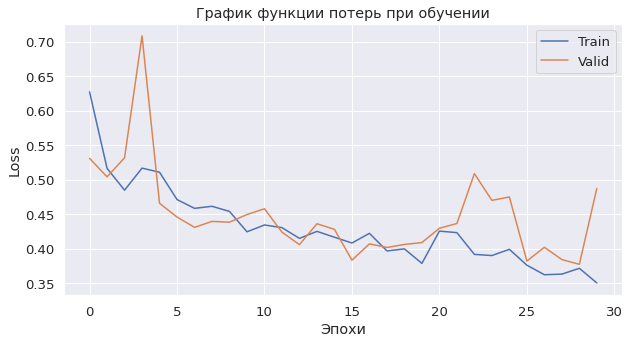

In [297]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(['Train', 'Valid'])
plt.title('График функции потерь при обучении')
plt.xlabel('Эпохи')
plt.ylabel('Loss');

In [298]:
# Загрузка обученной модели
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [299]:
# Предсказания вероятностей на валидационной выборке
with torch.no_grad():
    preds_val = model(val_seq.to(device), val_mask.to(device))
    preds_val = torch.exp(preds_val).detach().cpu().numpy()

              precision    recall  f1-score   support

           0       0.98      0.81      0.89       134
           1       0.55      0.94      0.70        33

    accuracy                           0.84       167
   macro avg       0.77      0.88      0.79       167
weighted avg       0.90      0.84      0.85       167

ROC-AUC модели: 0.93


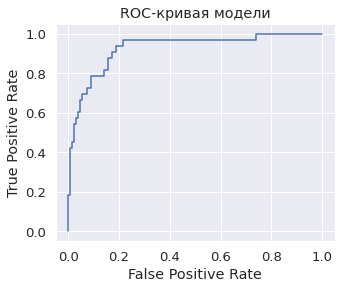

In [300]:
# Вывод резульатов валидации

preds_proba = preds_val[:,1]
preds_val = np.argmax(preds_val, axis=1)
fpr, tpr, thresholds = roc_curve(val_y, preds_proba)

print(classification_report(y_valid, preds_val))
print('ROC-AUC модели:', round(roc_auc_score(y_valid, preds_proba), 2))

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели');

### Предсказания на тестовой выборке

Тестовая выборка большая и не помещается в оперативную память видеокарты. Предсказания придется делать батчами.

In [301]:
pred_batch_size = 341 # Делитель тестовой выборки без остатка
preds_total = []

for i in notebook.tqdm(range(test.shape[0] // pred_batch_size)):
    seq = test_seq[pred_batch_size*i : pred_batch_size*(i+1)].to(device)
    mask = test_mask[pred_batch_size*i : pred_batch_size*(i+1)].to(device)

    with torch.no_grad():
        preds = model(seq, mask)

    preds = torch.exp(preds).cpu().numpy()
    preds_total.append(preds)
    
    del preds
    torch.cuda.empty_cache()

preds_total = np.concatenate(preds_total)

  0%|          | 0/31 [00:00<?, ?it/s]

In [305]:
# Проверка на соответствие размеров
preds_total.shape[0] == test.shape[0]

True

In [306]:
output['preds'] = preds_total[:,1]
output.to_csv(path+'/preds.csv', index=False)

In [ ]:
pd.read_csv(path+'/preds.csv')